# Demo: Defining WeatherForecast Workflows in Control-M using Python

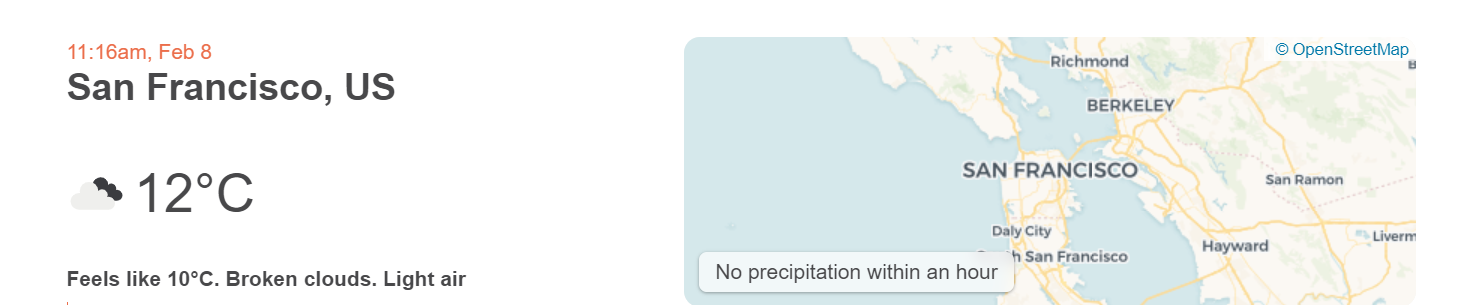

# Step 1 - Setup

## Step 1A - Install the library

In [ ]:
#!pip install git+https://github.com/controlm/ctm-python-client.git

## Step 1B- Import the library

In [ ]:
from ctm_python_client.core.bmc_control_m import CmJobFlow
from ctm_python_client.jobs.dummy import DummyJob
from ctm_python_client.jobs.command import CommandJob 

# Step 2 - Instantiate, Authenticate and Schedule


## Step 2A - Create the object

In [ ]:
import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/.secrets", "r") as fp:
    ctm_uri = fp.readline().strip()
    ctm_user = fp.readline().strip()
    ctm_pwd = fp.readline().strip()

In [ ]:
# Please change the URfrI, and ctm_user and enter ctm_password to match your environment
from ctm_python_client.session.session import Session

session = Session( endpoint=ctm_uri,username=ctm_user,password=ctm_pwd)
session.get_token()

In [ ]:
t1_flow = CmJobFlow(application="Demo",sub_application="Demo-02",session=session, ctm_uri=ctm_uri)

## Step 2B - Define the Flow Level Defaults

### Default run_as and host

In [ ]:
t1_flow.set_run_as(username="ctmuser",host="host")

### Define Default Schedule

In [ ]:
# Define the schedule
months = ["JAN", "OCT", "DEC"]
monthDays = ["ALL"]
weekDays = ["MON","TUE", "WED", "THU", "FRI"]
fromTime = "0300"
toTime = "2100"
t1_flow.set_schedule(months, monthDays, weekDays,fromTime, toTime)


# Step 3  - Folder

## Step 3A - Create Folder

In [ ]:
# Create Folder
f1 = t1_flow.create_folder(name="WeatherForecast")

### Step 3B - Define Variables

In [ ]:
#appid is the weather api token, you obtained during setup
variables = [ { "appid" : "apiid"}, 
              { "zipcode" : "95130"}, 
              { "email" : "mail@.com"} ]
t1_flow.add_variables(folder=f1, list_of_variables=variables)

# Step 4 - Create Tasks

In [ ]:
start = t1_flow.add_job(f1, DummyJob(folder= f1, job_name="StartFlow"))
end = t1_flow.add_job(f1, DummyJob(folder= f1, job_name="EndFlow"))


hostname = "hostname"
run_as="ctmuser"

#create job 1
j1 = CommandJob(folder=f1, job_name="GetMaxTemp", command="wget \"https://api.openweathermap.org/data/2.5/weather?zip=%%zipcode,us&appid=%%appid&units=imperial\" -O $HOME/output.json",
                              host=hostname, run_as=run_as)
GetMaxTemp =  t1_flow.add_job(folder=f1, job=j1)


#create job 2
j2 = CommandJob(folder=f1, job_name="CityVar", command="cd $HOME/ && city=$(cat output.json | jq -r \".name\") | echo \"$city\"",
                              host=hostname, run_as=run_as)
j2.capture_output( variable="city", capture_type="UpToEndOfLine", search_string="city=")
CityVar =  t1_flow.add_job(folder=f1, job=j2)

#create job 3
j3 = CommandJob(folder=f1, job_name="CountryVar", command="cd $HOME/ && country=$(cat output.json | jq -r \".sys.country\") | echo \"$country\"",
                              host=hostname, run_as=run_as)
j3.capture_output( variable="country", capture_type="UpToEndOfLine", search_string="country=")
CountryVar =  t1_flow.add_job(folder=f1, job=j3)

#create job 4
j4 = CommandJob(folder=f1, job_name="HighTempVar", command="cd $HOME/ && high_temp=$(cat output.json | jq \".main.temp_max\") | echo \"$high_temp\"",
                              host=hostname, run_as=run_as)
j4.capture_output( variable="hightemp", capture_type="UpToEndOfLine", search_string="high_temp=")
HighTempVar =  t1_flow.add_job(folder=f1, job=j4)

#create job 5
j5 = CommandJob(folder=f1, job_name="SendEmail", command="echo \\\"Today, the high temperature in %%city %%country is %%hightemp F.\\\"",
                              host=hostname, run_as=run_as)
j5.on_success_send_mail(mail_subject= "Today's High Temperature", mail_to="%%email", mail_message="Today, the high temperature in %%city %%country is %%hightemp F.")
SendEmail =  t1_flow.add_job(folder=f1, job=j5)




# Step 5 - Chain Tasks

In [ ]:
t1_flow.chain_jobs(f1,[start, GetMaxTemp, HighTempVar, SendEmail, end])
t1_flow.chain_jobs(f1,[GetMaxTemp,CountryVar,SendEmail])
t1_flow.chain_jobs(f1,[GetMaxTemp,CityVar,SendEmail])


# Step 6 - Display Workflow

## Step 6A - Display DAG

In [ ]:
from ctm_python_client.utils.displayDAG import DisplayDAG

DisplayDAG(t1_flow).display_graphviz()

## Step 6B - Display JSON

In [ ]:
t1_flow.display_json()

# Step 7 - Submit Workflow to Control-M

In [ ]:
t1_flow.run()